In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


# Ridge regression implementation for Medical cost prediction on insurance data 

## Step-1:Data loading and cleaning

In [2]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')

In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Step-2: Data Exploration

### Finding medical charges distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


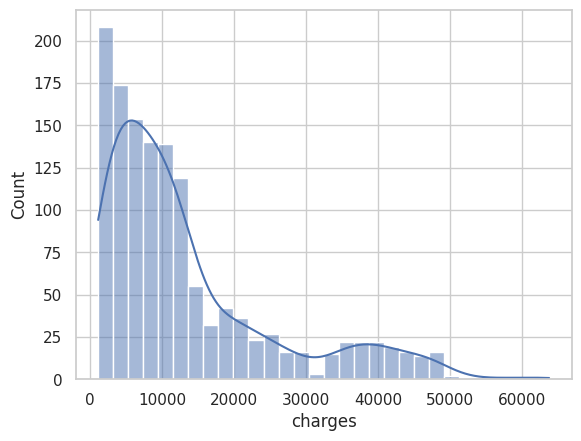

In [7]:
import seaborn as sns
sns.set(style='whitegrid')
plot_charges = sns.histplot(df['charges'],kde= True)

As we can see that charges data is Right-skewed which means that most of the medical charges are low to modrate.Which means majority of policy holders are incurring routine medical expenses.

### Exploring relationship of charges with gender

<Axes: xlabel='sex', ylabel='charges'>

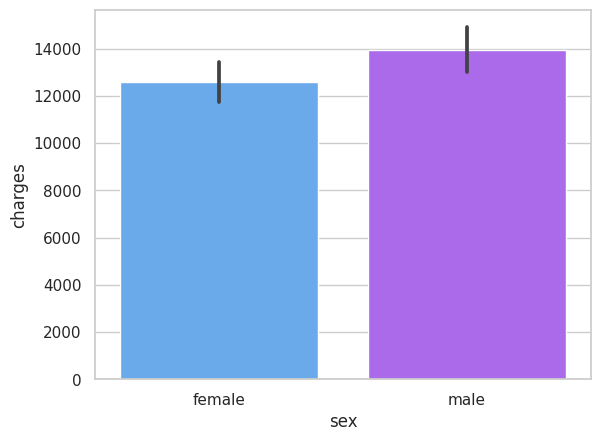

In [8]:
sns.barplot(x='sex',y='charges',data=df,palette='cool')

While males have higher average charges, the difference is not dramatically large, indicating that both genders likely face similar healthcare needs overall.

Charges vary significantly across regions, suggesting that location plays a role in healthcare costs.Charges vary significantly across regions, suggesting that location plays a role in healthcare costs.

Males might have higher charges due to riskier behaviors, higher smoking rates, or because of higher BMI

### Relationship between region and gender with respect to charges

<Axes: xlabel='sex', ylabel='charges'>

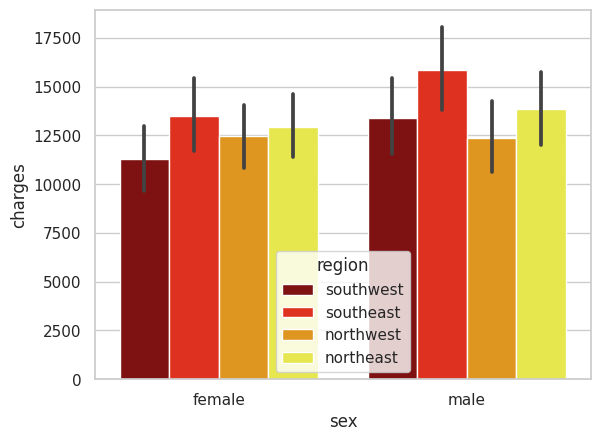

In [9]:
sns.barplot(x='sex',y='charges',hue='region',data=df,palette='hot')

In [10]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

### Exploring if the charges are related to dependents.

<Axes: xlabel='children', ylabel='charges'>

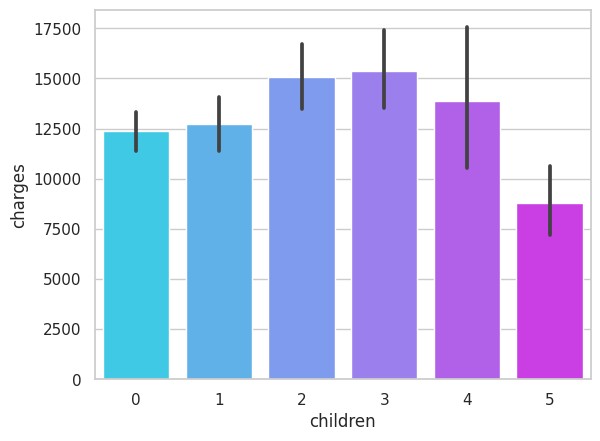

In [11]:
sns.barplot(x='children',y='charges',data=df,palette='cool')

Average charges increase as the number of children increases from 0 to 3.This trend reflects the additional healthcare costs associated with more dependents.Larger error bars for families with 3–4 children suggest greater variability in healthcare costs, likely due to outliers or diverse family healthcare needs.Families with 0–1 children show less variability, indicating more consistent healthcare costs for smaller families.

In [12]:
df['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

As we explore more, we can observe that there is inconsistency in data entries.

### Relationship with bmi and smokers

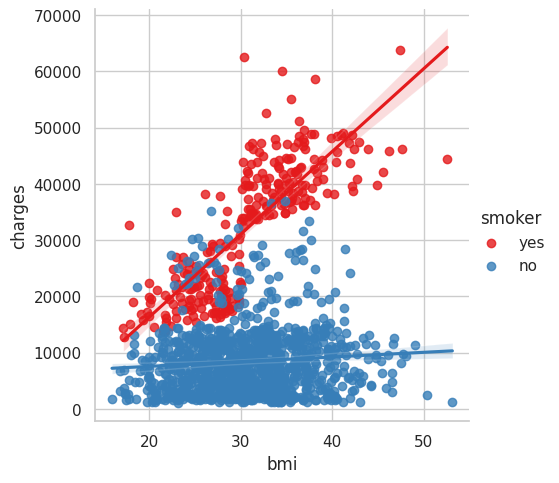

In [13]:
ax = sns.lmplot(x = 'bmi',y = 'charges', data = df, hue = 'smoker', palette = 'Set1')


Smokers (red points) have significantly higher charges compared to non-smokers, especially as BMI increases.The red trend line shows a steep positive slope, indicating a strong correlation between BMI and charges for smokers. Higher BMI among smokers leads to disproportionately higher medical expenses.

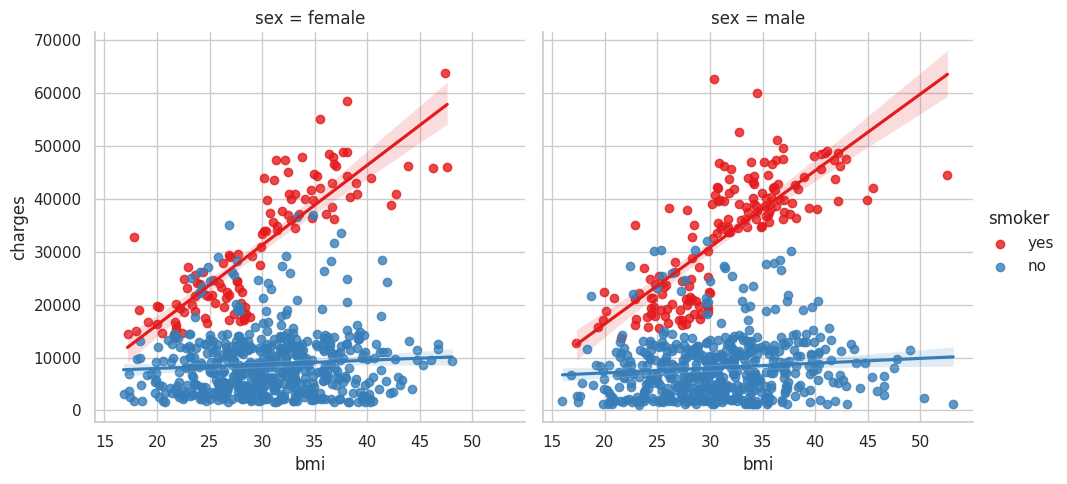

In [14]:
# Check the impact of sex in the relationship between BMI, charges, and smoking
ax = sns.lmplot(
    x='bmi', 
    y='charges', 
    data=df, 
    hue='smoker', 
    palette='Set1', 
    col='sex',  # Creates separate plots for each gender
    height=5, 
    aspect=1
)


Both males and females who smoke show a strong positive correlation between BMI and charges.Charges increase significantly with BMI for smokers in both genders, with males showing slightly higher overall charges.

## Step 3: Data preprocessing

### converting categorical labels to numerical

In [15]:
##Converting category labels into numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


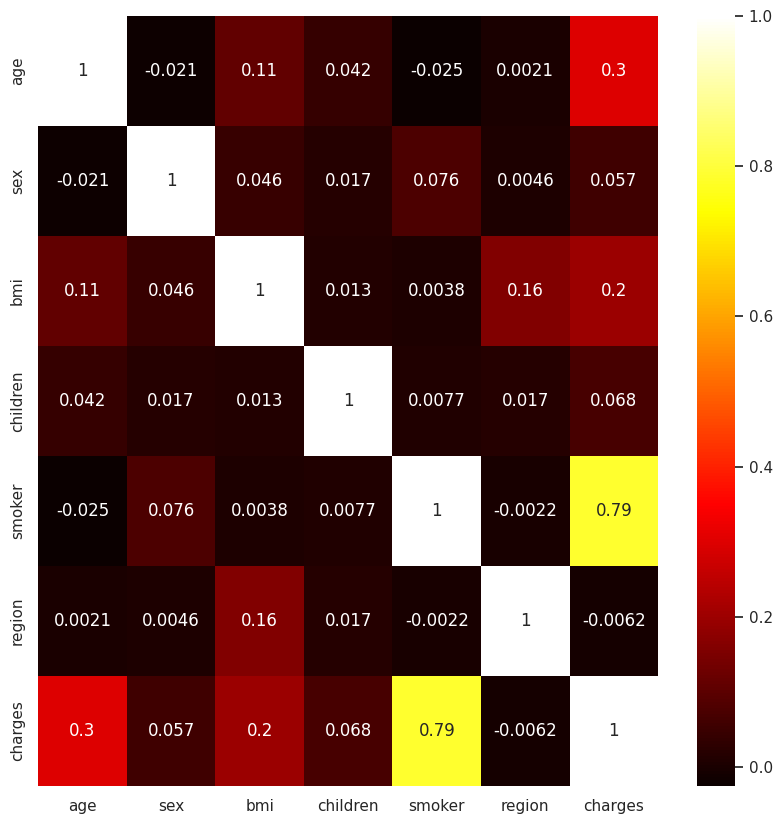

In [17]:
import matplotlib.pyplot as plt
f, plot_corr = plt.subplots(1, 1, figsize=(10, 10))
plot_corr = sns.heatmap(df.corr(), annot=True,cmap='hot')

### Train-test split

In [18]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [19]:
from sklearn.model_selection import train_test_split
X= df[['age', 'bmi', 'smoker']]
y= df['charges']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

#### Tranforming data points

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Step-4: Model Training

In [21]:
from sklearn.linear_model import Ridge
model_ridge = Ridge()
model_ridge.fit(X_train,y_train)

Ridge()

In [22]:
model_ridge.coef_

array([3645.50984406, 1970.50853942, 9559.14717266])

In [23]:
model_ridge.intercept_

13346.089736364485

In [24]:
# prediction for test data
y_pred= model_ridge.predict(X_test)

## Step-5: Model evalutation

In [25]:
# performance metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(f"MSE:{round(mse,2)},\nMAE:{round(mae,2)},\nRMSE:{round(rmse,2)}")

MSE:34517993.03,
MAE:4262.0,
RMSE:5875.2


In [26]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred)
score

0.7776600639630283

In [27]:
# adjusted r-squared
1 - (1- score)* (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.77513347378079

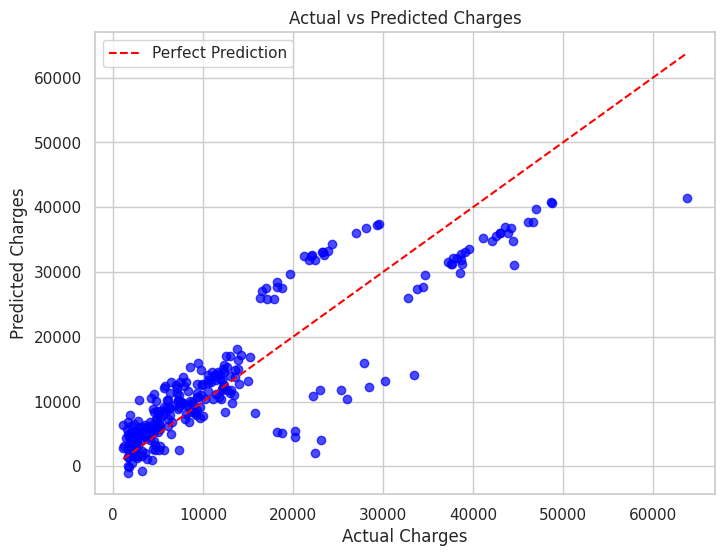

In [28]:
import matplotlib.pyplot as plt
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.title("Actual vs Predicted Charges")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.legend()
plt.grid(True)
plt.show()

## Step-6: Model optimisation 

### introducing features

In [29]:
from sklearn.model_selection import train_test_split
X= df[['age', 'bmi', 'smoker','region','sex','children']]
y= df['charges']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
from sklearn.linear_model import Ridge
model_ridge_2 = Ridge()
model_ridge_2.fit(X_train,y_train)

Ridge()

In [32]:
# prediction for test data
y_pred_2 = model_ridge_2.predict(X_test)

In [33]:
model_ridge_2.coef_

array([ 3.61244853e+03,  2.02671768e+03,  9.54798452e+03, -3.01857800e+02,
       -8.73095622e+00,  5.16517239e+02])

In [34]:
# performance metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
mse = mean_squared_error(y_test,y_pred_2)
mae = mean_absolute_error(y_test,y_pred_2)
rmse = np.sqrt(mse)
print(f"MSE:{round(mse,2)},\nMAE:{round(mae,2)},\nRMSE:{round(rmse,2)}")

MSE:33641818.59,
MAE:4187.97,
RMSE:5800.16


In [35]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred_2)
score

0.7833037457661384

In [36]:
# adjusted r-squared
1 - (1- score)* (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.7783222226803025

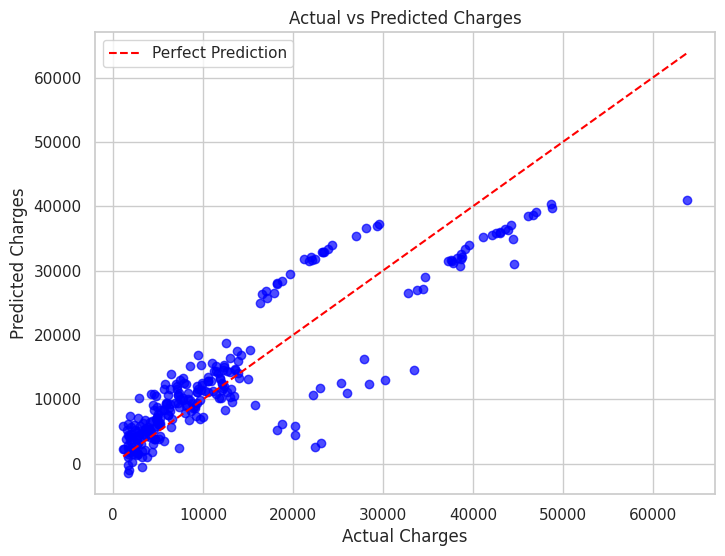

In [37]:
import matplotlib.pyplot as plt
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_2, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.title("Actual vs Predicted Charges")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.legend()
plt.grid(True)
plt.show()

As we can observe, just by introducing more features we have achieved improved MSE,MAE and RMSE evaluation score with improved model accuracy.

## Step-7: Cross validation

In [38]:
from sklearn.linear_model import RidgeCV
model_ridge_cv = RidgeCV()
model_ridge_cv.fit(X_train,y_train)

RidgeCV()

In [39]:
# prediction for test data
y_pred_3 = model_ridge_2.predict(X_test)

In [40]:
model_ridge_cv.coef_

array([ 3.61244853e+03,  2.02671768e+03,  9.54798452e+03, -3.01857800e+02,
       -8.73095622e+00,  5.16517239e+02])

## Step-8: Hyperparameter Tunning

In [41]:
model_ridge_2.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky']
}
# Initialize Ridge model
ridge = Ridge()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Change scoring metric if needed
    cv=5,
    n_jobs=-1  # Use all available processors
)

# Fit the model on your training data
grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

# Full results
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df)


Best Parameters: {'alpha': 1.0, 'fit_intercept': True, 'solver': 'svd'}
Best Score (MSE): 37830107.434964076
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.002821      0.000281         0.000817        0.000061        0.01   
1        0.002217      0.000399         0.000901        0.000337        0.01   
2        0.001787      0.000100         0.000713        0.000065        0.01   
3        0.001700      0.000057         0.000693        0.000035        0.01   
4        0.002115      0.000261         0.000723        0.000054        0.01   
5        0.001741      0.000094         0.000713        0.000026        0.01   
6        0.001878      0.000189         0.000690        0.000049         0.1   
7        0.001917      0.000132         0.000663        0.000067         0.1   
8        0.001782      0.000191         0.000647        0.000038         0.1   
9        0.001614      0.000119         0.000695        0.000030         0.1   
10       0.

In [43]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [0.8, 0.9, 1.0, 1.1, 1.2], 'solver': ['svd'], 'fit_intercept': [True]}

# Initialize Ridge model
ridge = Ridge()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Change scoring metric if needed
    cv=5,
    n_jobs=-1  # Use all available processors
)

# Fit the model on your training data
grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

# Full results
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df)


Best Parameters: {'alpha': 1.2, 'fit_intercept': True, 'solver': 'svd'}
Best Score (MSE): 37829848.50143304
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.002026      0.000160         0.000730        0.000059         0.8   
1       0.002099      0.000165         0.000704        0.000054         0.9   
2       0.002355      0.000456         0.000764        0.000039         1.0   
3       0.001965      0.000098         0.000725        0.000054         1.1   
4       0.002036      0.000362         0.000616        0.000109         1.2   

  param_fit_intercept param_solver  \
0                True          svd   
1                True          svd   
2                True          svd   
3                True          svd   
4                True          svd   

                                              params  split0_test_score  \
0  {'alpha': 0.8, 'fit_intercept': True, 'solver'...      -4.010260e+07   
1  {'alpha': 0.9, 'fit_intercept': Tru

In [44]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the final model
final_model = Ridge(alpha=1.2, fit_intercept=True, solver='svd')
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MSE: 33643163.83
MAE: 4188.26
RMSE: 5800.27
R² Score: 0.7833
